### **Objetivo**

Crear un pequeño framework de visualización genérico que pueda adaptarse fácilmente a nuevas fuentes de datos.

#### **Diagrama**

1. AbstractDataSource (interfaz)

    - Método: get_dataframe() -> pd.DataFrame (abstracto)

    - Como obtener los datos y convertirlos en dataframe.

2. CSVDataSource

    - Método: get_dataframe() → pd.DataFrame

    - Carga el CSV

3. AbstractCleaner (interfaz)

    - Método: clean(dataframe: pd.DataFrame) → pd.DataFrame (abstracto)

    - Aplica la transformación y limpieza.

4. AccidentsCleaner (implementa AbstractCleaner)

    - Contiene la lógica de limpieza e imputación específica del dataset de accidentes.

5. VisualizationStrategy (interfaz)

    - Método: plot(dataframe: pd.DataFrame) (abstracto)

    - Define la interfaz para representr el dataframe en graficos.

6. LineChartStrategy / BarChartStrategy (implementan VisualizationStrategy)

    - Implementan graficas específicas, en este caso lineas y barras.

7. Visualizer

    - set_strategy(strategy: VisualizationStrategy)

    - render(dataframe: pd.DataFrame)

#### **Técnologías usadas**

- Python 3.10+

- Pandas: para manipulación de datos.

- Matplotlib / Seaborn / Plotly: para visualizaciones.

- Jupyter Notebook: entorno de desarrollo y presentación.

- Patrón de diseño: Strategy Pattern, para desacoplar visualización y fuentes de datos.

In [2]:
import pandas as pd
from datasource import CSVDataSource
from cleaner import GenericCleaner
from visualizer import Visualizer
from strategies import BarChartStrategy, LineChartStrategy, ScatterStrategy, HistogramStrategy
import ipywidgets as widgets
from IPython.display import display
import sys

In [3]:
# cargar y limpiiar
source = CSVDataSource("US_Accidents_March23.csv")
df = source.get_dataframe()

cleaner = GenericCleaner(
    cols_to_drop=[
        'Description', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
        'Source', 'Country', 'Distance(mi)', 'Airport_Code', 'Weather_Timestamp',
        'Timezone', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'
    ],
    cols_required=['Street', 'City', 'Zipcode', 'Sunrise_Sunset'],
    cols_fill_mean=[
        'Temperature(F)', 'Wind_Chill(F)', 'Precipitation(in)', 'Wind_Speed(mph)',
        'Visibility(mi)', 'Pressure(in)', 'Humidity(%)'
    ],
    cols_fill_mode=['Weather_Condition', 'Wind_Direction']
)
df = cleaner.clean(df)

In [4]:
## procesar fecha y hora porque da error por los milisegundos
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Start_Time'])  # Eliminar fechas no válidas
df['Hour'] = df['Start_Time'].dt.hour

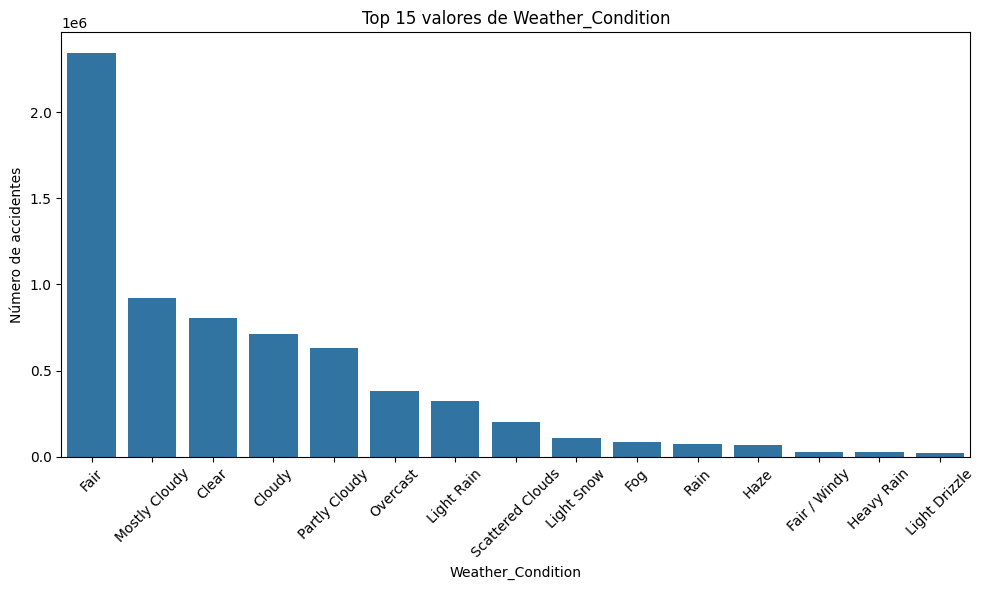

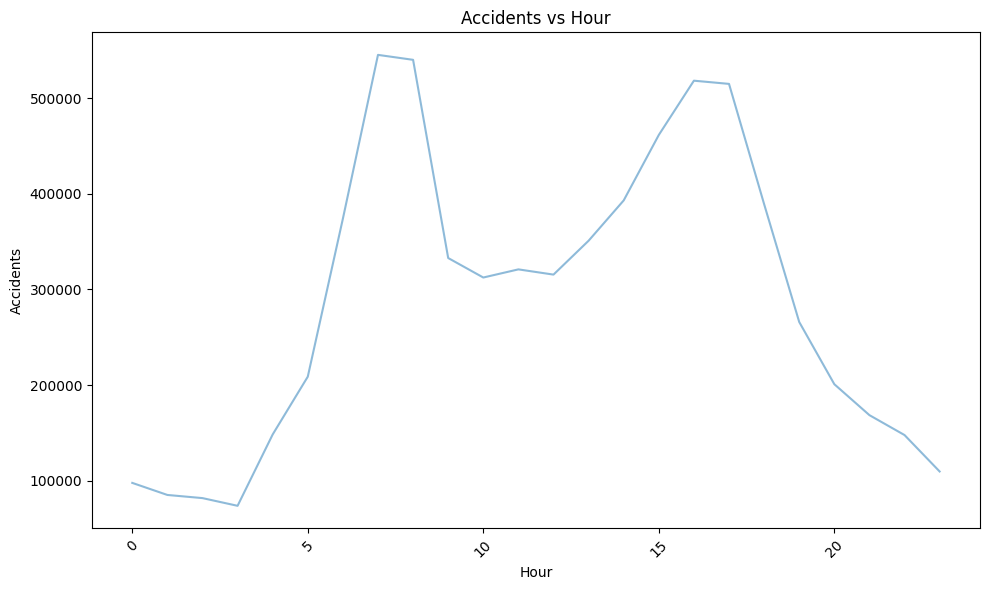

In [5]:
# 3. Visualizador
viz = Visualizer()

# A. BARRAS: Accidentes por condición meteorológica (Weather_Condition)
viz.set_strategy(BarChartStrategy(x='Weather_Condition', top_n=15))
viz.render(df)

# B. LÍNEAS: Evolución del número de accidentes por hora del día
accidents_per_hour = df['Hour'].value_counts().sort_index()
df_hourly = pd.DataFrame({'Hour': accidents_per_hour.index, 'Accidents': accidents_per_hour.values})

viz.set_strategy(LineChartStrategy(x='Hour', y='Accidents'))
viz.render(df_hourly)



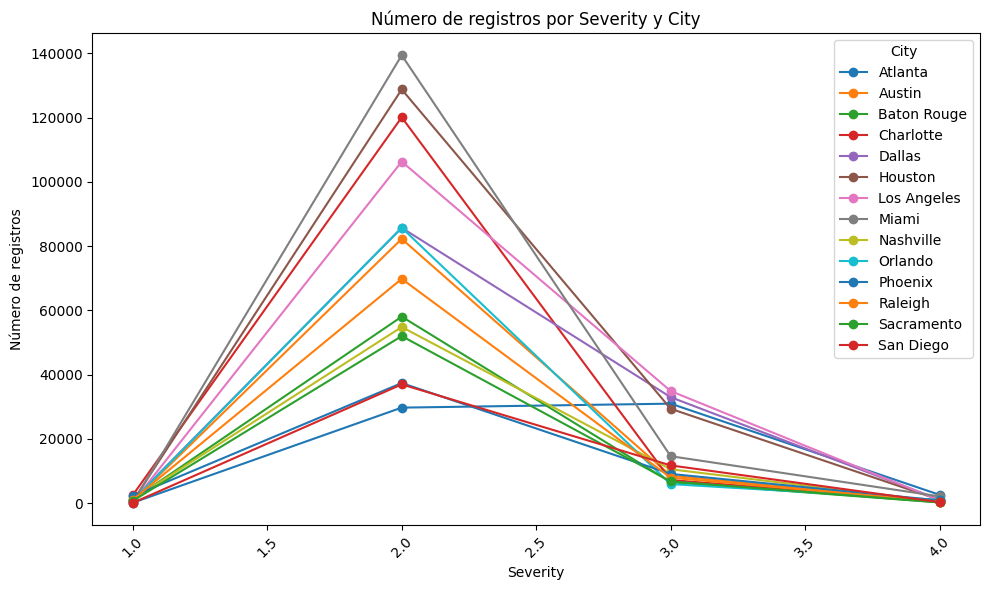

In [8]:
# Jupyter cell: Multi‑line plot para LineChartStrategy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Widgets para ejes y agrupación
default_top_n = 10
num_vars  = df.select_dtypes('number').columns.tolist()
cat_vars  = df.select_dtypes('object').columns.tolist()
x_sel     = widgets.Dropdown(options=num_vars, description='Eje X:')
y_sel     = widgets.Dropdown(options=num_vars, description='Eje Y:')
grp_sel   = widgets.Dropdown(options=[None]+cat_vars, description='Agrupar por:')
top_n_sel = widgets.IntSlider(value=default_top_n, min=2, max=20, step=1, description='Top N:')
btn       = widgets.Button(description='Dibujar líneas')
ui = widgets.VBox([x_sel, y_sel, grp_sel, top_n_sel, btn])
display(ui)

# Función para plot multi-línea
# Función para plot multi-línea (agregado de recuentos)
def plot_multi_line(df, x, y, group_by, top_n):
    # filtrar top_n categorías
    if group_by:
        top_cats = df[group_by].value_counts().nlargest(top_n).index
        df = df[df[group_by].isin(top_cats)]
    # preparar figura
    plt.figure(figsize=(10,6))
    # para cada grupo, calcular recuento de casos por valor de x
    for name, grp in df.groupby(group_by):
        # conteo de accidentes por valor de x
        counts = grp[x].value_counts().sort_index()
        # dibujar línea de recuentos
        plt.plot(counts.index, counts.values, marker='o', label=name)
    # decoraciones
    plt.xlabel(x)
    plt.ylabel('Número de registros')
    plt.title(f'Número de registros por {x} y {group_by}')
    plt.legend(title=group_by)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Handler actualizado
def on_click(_):
    clear_output(wait=True)
    display(ui)
    x     = x_sel.value
    y     = y_sel.value    # ignorado en line plot, usamos recuentos de x
    grp   = grp_sel.value
    top_n = top_n_sel.value
    plot_multi_line(df, x, y, grp, top_n)

btn.on_click(on_click)



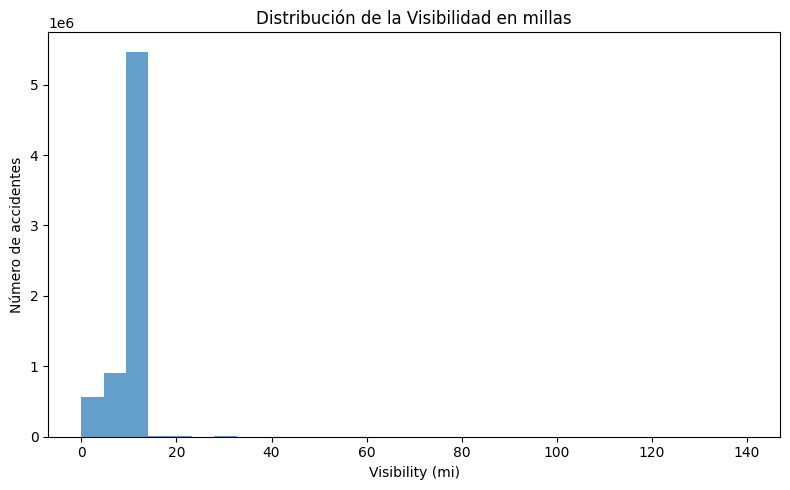

In [10]:
plt.figure(figsize=(8,5))
plt.hist(df['Visibility(mi)'], bins=30, alpha=0.7)
plt.title("Distribución de la Visibilidad en millas")
plt.xlabel("Visibility (mi)")
plt.ylabel("Número de accidentes")
plt.tight_layout()
plt.show()


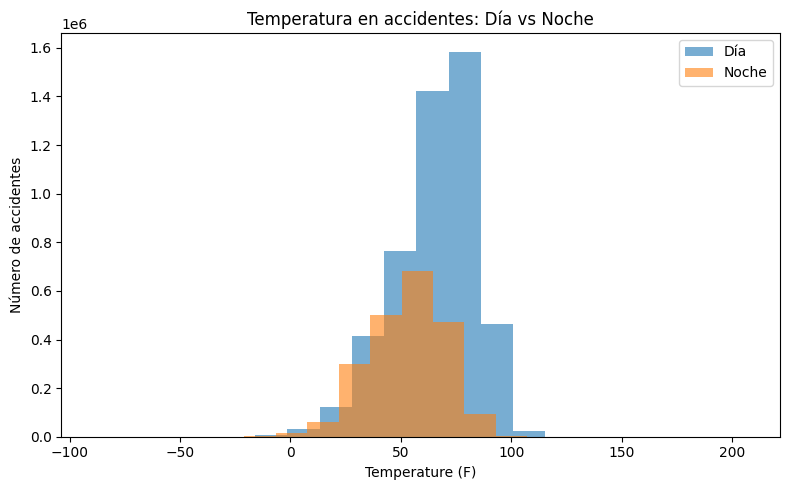

In [11]:
# Separamos en dos grupos según Sunrise_Sunset
day   = df[df['Sunrise_Sunset']=='Day']['Temperature(F)']
night = df[df['Sunrise_Sunset']=='Night']['Temperature(F)']

plt.figure(figsize=(8,5))
plt.hist(day,   bins=20, alpha=0.6, label='Día')
plt.hist(night, bins=20, alpha=0.6, label='Noche')
plt.title("Temperatura en accidentes: Día vs Noche")
plt.xlabel("Temperature (F)")
plt.ylabel("Número de accidentes")
plt.legend()
plt.tight_layout()
plt.show()


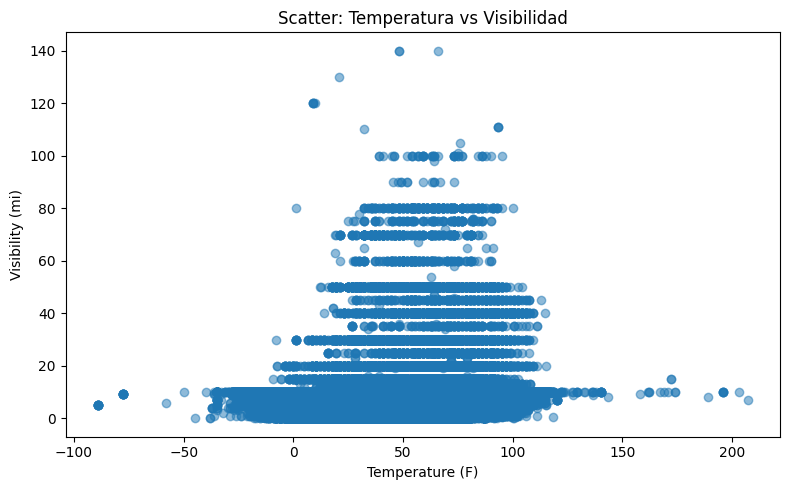

In [12]:
# Scatter Plot 1: Temperature(F) vs Visibility(mi)
plt.figure(figsize=(8,5))
plt.scatter(df['Temperature(F)'], df['Visibility(mi)'], alpha=0.5)
plt.title("Scatter: Temperatura vs Visibilidad")
plt.xlabel("Temperature (F)")
plt.ylabel("Visibility (mi)")
plt.tight_layout()
plt.show()


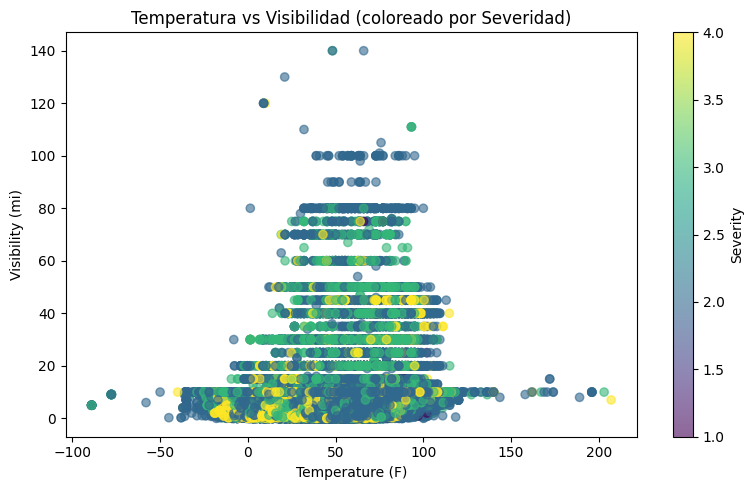

In [13]:
# Scatter Plot 2: Temperature vs Visibility, coloreado por Severity
plt.figure(figsize=(8,5))
# map Severity a un colormap
severity = df['Severity']
scatter = plt.scatter(
    df['Temperature(F)'], 
    df['Visibility(mi)'], 
    c=severity, 
    cmap='viridis', 
    alpha=0.6
)
plt.colorbar(scatter, label='Severity')
plt.title("Temperatura vs Visibilidad (coloreado por Severidad)")
plt.xlabel("Temperature (F)")
plt.ylabel("Visibility (mi)")
plt.tight_layout()
plt.show()
